# Yolo-v12 and visual prompt chaining -- by Nandini Lokesh Reddy

In [32]:
!pip install --q ultralytics


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


#### if yolov-12 doesn't work, you can use any of yolo models for object detection

#### * all images are from google

# Define object tracker class

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time
from datetime import datetime
from ultralytics import YOLO
from openai import OpenAI


class ObjectTracker:
    def __init__(self, buffer_seconds=60.0):
        """Initialize the object tracker with a time buffer"""
        self.detection_history = deque(maxlen=30)
        self.buffer_time = buffer_seconds
    
    def process_detection(self, image, model):
        """Process an image with YOLO and track the detection sequence"""
        results = model(image)[0]
        current_time = time.time()
        detections = []
        for box in results.boxes.data.tolist():
            x1, y1, x2, y2, conf, class_id = box
            class_id = int(class_id)
            class_name = model.names[class_id]
            
            detections.append({
                'class_name': class_name,
                'confidence': conf,
                'box': [x1, y1, x2, y2]
            })
        if detections:
            self.detection_history.append({
                'timestamp': current_time,
                'detections': detections.copy()
            })
            self._clean_history(current_time)
            
        return detections
    
    def _clean_history(self, current_time):
        """Remove detections older than buffer_time"""
        while (self.detection_history and 
               current_time - self.detection_history[0]['timestamp'] > self.buffer_time):
            self.detection_history.popleft()
    
    def get_raw_detection_sequence(self):
        """Get the complete sequence of all detections in order, with duplicates"""
        sequence = []
        
        for entry in self.detection_history:
            for det in entry['detections']:
                sequence.append({
                    'class_name': det['class_name'],
                    'confidence': det['confidence'],
                    'timestamp': entry['timestamp']
                })
        sequence.sort(key=lambda x: x['timestamp'])
        
        return sequence
    
    def get_unique_objects_sequence(self):
        """Get unique objects in order of first appearance"""
        sequence = []
        seen = set()
        
        for entry in self.detection_history:
            for det in entry['detections']:
                class_name = det['class_name']
                if class_name not in seen:
                    sequence.append(class_name)
                    seen.add(class_name)
        
        return sequence
    
    def get_confidence_weighted_objects(self):
        """Get objects weighted by their detection confidence"""
        confidence_map = {}
        
        for entry in self.detection_history:
            for det in entry['detections']:
                class_name = det['class_name']
                confidence = det['confidence']
                
                if class_name not in confidence_map or confidence > confidence_map[class_name]:
                    confidence_map[class_name] = confidence

        sorted_objects = sorted(confidence_map.items(), key=lambda x: x[1], reverse=True)
        return sorted_objects

# Define GPT response generator

In [30]:
def generate_gpt_response(sequence, user_profile=None):
    """Generate a response from GPT based on detected objects"""
    if user_profile is None:
        user_profile = {
            "name": "Nandini",
            "profession": "Data Scientist",
            "interests": ["computer vision", "machine learning", "data analysis"]
        }
    
    # STEP 2.1: Get API key from environment variable
    api_key = os.environ.get("OPENAI_API_KEY")
    
    # Check if API key exists
    if not api_key:
        print("\nError: OpenAI API key not found!")
        print("Please set your API key as an environment variable:")
        print("  For Windows: set OPENAI_API_KEY=your-api-key-here")
        print("  For macOS/Linux: export OPENAI_API_KEY=your-api-key-here")
        return "Error: API key not configured. See console for instructions."
    
    try:
        # STEP 2.2: Initialize the OpenAI client with the API key
        client = OpenAI(api_key=api_key)
        
        # STEP 2.3: Create system prompt for GPT
        system_message = f"""
        You are a helpful AI assistant integrated with a computer vision system. 
        You're talking to {user_profile['name']}, who works as a {user_profile['profession']}. 
        Be friendly and personable.
        
        When you see work-related objects, share recent interesting AI developments.
        When you see everyday objects, provide practical insights.
        
        Keep your response under 150 words and make it conversational.
        """
        
        # STEP 2.4: Get current time for context
        current_datetime = datetime.now().strftime("%A, %B %d, %Y at %I:%M %p")
        
        # STEP 2.5: Generate dynamic prompt based on detected objects
        objects_str = ", ".join(sequence)
        prompt = f"""
        Based on the objects I can see ({objects_str}), generate a relevant response
        that considers my current context. What interesting AI developments or insights
        might be relevant to my current environment? Please be specific to what you can see.
        """
        
        # STEP 2.6: Build the messages for the GPT API
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": f"""
            The computer vision system has detected: {', '.join(sequence)}
            Current time: {current_datetime}
            
            {prompt}
            """}
        ]
        
        print(f"\nSending request to GPT with detected objects: {sequence}")
        
        # STEP 2.7: Call the GPT API
        response = client.chat.completions.create(
            model="gpt-4",
            messages=messages,
            max_tokens=200,
            temperature=0.7
        )
        
        # STEP 2.8: Extract and return the response
        gpt_response = response.choices[0].message.content
        return gpt_response
        
    except Exception as e:
        print(f"\nError generating GPT response: {e}")
        return f"Error: Could not generate GPT response. {str(e)}"

# Main Function

Starting Object Detection to GPT Pipeline...
Loading YOLO model...
YOLO model loaded successfully
Loading image from: image2.png
Image loaded successfully
Initializing object tracker...
Processing image with YOLO...

0: 448x640 1 cup, 1 bowl, 1 potted plant, 1 dining table, 1 tv, 1 laptop, 2 books, 1 vase, 87.9ms
Speed: 6.3ms preprocess, 87.9ms inference, 9.5ms postprocess per image at shape (1, 3, 448, 640)

Extracting detection sequences...

--- Detection Results ---

Raw detection sequence:
laptop (confidence: 0.91)
potted plant (confidence: 0.74)
cup (confidence: 0.56)
tv (confidence: 0.47)
book (confidence: 0.40)
bowl (confidence: 0.38)
book (confidence: 0.37)
dining table (confidence: 0.36)
vase (confidence: 0.26)

Unique objects in order of appearance:
['laptop', 'potted plant', 'cup', 'tv', 'book', 'bowl', 'dining table', 'vase']

Objects by confidence:
laptop: 0.91
potted plant: 0.74
cup: 0.56
tv: 0.47
book: 0.40
bowl: 0.38
dining table: 0.36
vase: 0.26

Generating visualizati

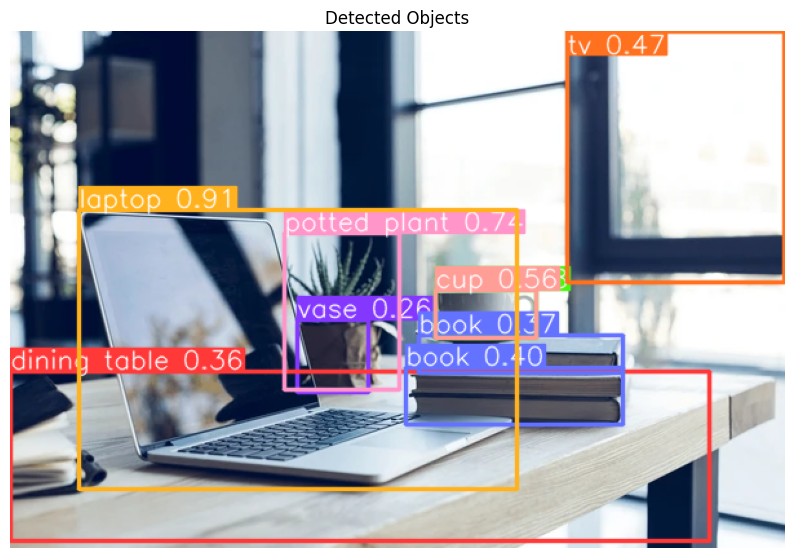


Generating GPT response based on detected objects...

Sending request to GPT with detected objects: ['laptop', 'potted plant', 'cup', 'tv', 'book', 'bowl', 'dining table', 'vase']

--- GPT Response Based on Detected Objects ---
Sure thing, Nandini! Since you're likely wrapping up your day, here's a blend of work and relaxation insights. 

On the work front (laptop and book), there's a fascinating development in AI - federated learning. It allows machine learning models to be trained across multiple devices or servers holding local data samples, without sharing them. This could be a big step in maintaining data privacy!

As for relaxation (tv, potted plant), did you know some smart TVs now use AI to enhance image quality in real-time? Also, a recent study showed that having plants in your room can improve air quality and reduce stress levels. 

Lastly, your table setup (dining table, cup, bowl, vase) is perfect for a cozy meal. Enjoy your evening, Nandini!

--- End of Pipeline ---


In [ ]:
def main():
    """Main function to run the object detection and GPT response pipeline"""
    print("Starting Object Detection to GPT Pipeline...")
    
    # STEP 3.1: Load the YOLO model
    print("Loading YOLO model...")
    try:
        model = YOLO('yolo12n.pt')
        print("YOLO model loaded successfully")
    except Exception as e:
        print(f"Error loading YOLO model: {e}")
        return
    
    # STEP 3.2: Load the image
    image_path = 'image2.png'
    print(f"Loading image from: {image_path}")
    
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            print("Make sure the image file exists in the current directory")
            return
        print("Image loaded successfully")
    except Exception as e:
        print(f"Error loading image: {e}")
        return
    
    # STEP 3.3: Initialize the object tracker
    print("Initializing object tracker...")
    tracker = ObjectTracker()
    
    # STEP 3.4: Process the detection with the tracker
    print("Processing image with YOLO...")
    detections = tracker.process_detection(image, model)
    
    if not detections:
        print("No objects detected in the image")
        return
    
    # STEP 3.5: Get different representations of the detection sequence
    print("\nExtracting detection sequences...")
    raw_sequence = tracker.get_raw_detection_sequence()
    unique_sequence = tracker.get_unique_objects_sequence()
    confidence_weighted = tracker.get_confidence_weighted_objects()
    
    # STEP 3.6: Display detection results
    print("\n--- Detection Results ---")
    print("\nRaw detection sequence:")
    for det in raw_sequence:
        print(f"{det['class_name']} (confidence: {det['confidence']:.2f})")
    
    print("\nUnique objects in order of appearance:")
    print(unique_sequence)
    
    print("\nObjects by confidence:")
    for obj, conf in confidence_weighted:
        print(f"{obj}: {conf:.2f}")
    
    # STEP 3.7: Visualize the results with matplotlib
    print("\nGenerating visualization...")
    try:
        annotated_image = model(image)[0].plot()
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(annotated_image_rgb)
        plt.axis('off')
        plt.title('Detected Objects')
        plt.show()
    except Exception as e:
        print(f"Error generating visualization: {e}")
    
    # STEP 3.8: Generate GPT response if objects were detected
    if unique_sequence:
        print("\nGenerating GPT response based on detected objects...")

        user_profile = {
            "name": "Nandini", 
            "profession": "Data Scientist",
            "interests": ["computer vision", "machine learning", "data analysis"]
        }
        
        response = generate_gpt_response(unique_sequence, user_profile)
        print("\n--- GPT Response Based on Detected Objects ---")
        print(response)
        print("\n--- End of Pipeline ---")
    else:
        print("No objects detected to generate a GPT response")


if __name__ == "__main__":
    main()